<a href="https://colab.research.google.com/github/linlcc/Image-Classifier/blob/master/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classifier**
##### In this project, we will train an image classifier that can be trained on any set of labeled images. We will use this application to identify different kind of flowers here. This is pretty much the same as the application in your phone that tells you the name of flower from your photo. The background knowledge is to train a classifier, then export the model to the device you want to use for identification of the flowers. 

##### In this example, [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) which contains 102 categories of flower

#### This project will break down into few steps:
1. Load data and pre-process data
2. Train the model for classification
3. Predict the new image by the trained model






#### **Import and Load the dataset**

##### The dataset is already split into training, validation and testing. For the training, we will apply transformations like random scaling, cropping and resizing. Also, Because of the pre-trained model we will use later, we need to follow its expection of the images as below.

##### *All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].*

##### The test set and validation set are the dataset that to evaluate the trained model's performance. Therefore, there is no need to do any scaling and other transformations, just resize the images to the appropriate size.


In [1]:
# import
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
from collections import OrderedDict
import time
from PIL import Image
import matplotlib
import os, random

In [2]:
# Load the dataset
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
!wget https://raw.githubusercontent.com/linlcc/flower_classifier/master/cat_to_name.json
!mkdir flowers 
!tar -xzf flower_data.tar.gz -C flowers
#!rm -rf jpg
#!mv jpg flowers
data_dir="flowers"
train_dir=data_dir+"/train"
valid_dir=data_dir+"/valid"
test_dir=data_dir+"/test"

--2020-06-30 06:13:38--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.24.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.24.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz’

flower_data.tar.gz  100%[===================>] 328.90M  32.8MB/s    in 11s     

2020-06-30 06:13:49 (30.9 MB/s) - ‘flower_data.tar.gz’ saved [344873452/344873452]

--2020-06-30 06:13:50--  https://raw.githubusercontent.com/linlcc/flower_classifier/master/cat_to_name.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218 (2.2K) [text/plain]
Saving to: ‘cat_to_name.json’

cat_to_name.json    100%

In [3]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
image_datasets = {}
image_datasets["train"] = datasets.ImageFolder(train_dir, transform=train_transforms)
image_datasets["valid"] = datasets.ImageFolder(valid_dir, transform=valid_transforms)
image_datasets["test"] = datasets.ImageFolder(test_dir, transform=test_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(image_datasets["train"], batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(image_datasets["valid"], batch_size=32)
test_loader = torch.utils.data.DataLoader(image_datasets["test"], batch_size=32)

In [4]:
import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [5]:
# Load in a pre-trained model, DenseNet
model = models.densenet121(pretrained=True)
# model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


#### **Training Model**

##### We will use the pretrained models from torchvision.models to get the image features. Build and train a new feed-forward classifier using those features.

##### We will have 4 steps need to do:
+ Load a pre-trained network
+ Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
+ Train the classifier layers using backpropagation using the pre-trained network to get the features
+ Track the loss and accuracy on the validation set to determine the best hyperparameters




In [6]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
for param in model.parameters():
    param.requires_grad = False # Freeze parameters so we don't backprop through them

classifier = nn.Sequential(OrderedDict([
                          ('dropout1', nn.Dropout(0.1)),
                          ('fc1', nn.Linear(1024, 512)), # should be 1024 to match the pretrained model
                          ('relu1', nn.ReLU()),
                          ('dropout2', nn.Dropout(0.1)),
                          ('fc2', nn.Linear(512, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [7]:
# Measure the validation loss and accuracy
def validation(model, dataloader, criterion, device):
    loss = 0.0
    accuracy = 0.0
    with torch.no_grad():
        for images, labels in iter(dataloader):  
            images, labels = images.to(device), labels.to(device) # Move to GPU
            output = model.forward(images)
            loss += criterion(output, labels).item()

            ps = torch.exp(output) # get the class probabilities from log-softmax
            equality = (labels.data == ps.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
    
    return loss, accuracy

In [8]:
# Criterion and optimizer
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [9]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 10
steps = 0
running_loss = 0
train_accuracy = 0
start = time.time()

try:
    for e in range(epochs):
        model.train() # Dropout is turned on for training
        for images, labels in iter(train_loader):
            images, labels = images.to(device), labels.to(device) # Move to GPU
            steps += 1
            optimizer.zero_grad()
            # Forward
            output = model.forward(images)
            loss = criterion(output, labels)
            # Backward
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Get the class probabilities from log-softmax
            ps = torch.exp(output) 
            equality = (labels.data == ps.max(dim=1)[1])
            train_accuracy += equality.type(torch.FloatTensor).mean()

            if steps % len(train_loader) == 0:
                model.eval() # Validate in each epoch

                with torch.no_grad():
                    valid_running_loss, valid_accuracy = validation(model, valid_loader, criterion, device)

                print("Epoch: {}/{} ".format(e+1, epochs),
                      "\nTraining Loss: {:.4f} ".format(running_loss/len(train_loader)),
                      "Training Accuracy: {:.4f}".format(train_accuracy/len(train_loader)),
                      "Validation Loss: {:.4f} ".format(valid_running_loss/len(valid_loader)),
                      "Validation Accuracy: {:.4f}".format(valid_accuracy/len(valid_loader)))

                running_loss = 0
                train_accuracy = 0
                model.train() # Make sure training is back on

    time_elapsed = time.time() - start            
    print("Total time: {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed % 60))
except KeyboardInterrupt:
    print("Exiting loop")

Epoch: 1/10  
Training Loss: 3.0982  Training Accuracy: 0.3406 Validation Loss: 1.3268  Validation Accuracy: 0.7304
Epoch: 2/10  
Training Loss: 1.2969  Training Accuracy: 0.6955 Validation Loss: 0.6390  Validation Accuracy: 0.8647
Epoch: 3/10  
Training Loss: 0.8861  Training Accuracy: 0.7814 Validation Loss: 0.4422  Validation Accuracy: 0.9029
Epoch: 4/10  
Training Loss: 0.7458  Training Accuracy: 0.8138 Validation Loss: 0.3725  Validation Accuracy: 0.9101
Epoch: 5/10  
Training Loss: 0.6361  Training Accuracy: 0.8326 Validation Loss: 0.3221  Validation Accuracy: 0.9233
Epoch: 6/10  
Training Loss: 0.5922  Training Accuracy: 0.8428 Validation Loss: 0.3085  Validation Accuracy: 0.9209
Epoch: 7/10  
Training Loss: 0.5652  Training Accuracy: 0.8517 Validation Loss: 0.2950  Validation Accuracy: 0.9233
Epoch: 8/10  
Training Loss: 0.5310  Training Accuracy: 0.8579 Validation Loss: 0.2515  Validation Accuracy: 0.9318
Epoch: 9/10  
Training Loss: 0.4996  Training Accuracy: 0.8558 Validatio

#### **Testing the trained model**

##### Run the test images through the network and measure the accuracy, the same way we did validation. This will give a good estimate for the model's performance on completely new images.


In [10]:
model.eval()
with torch.no_grad():
    test_loss, test_accuracy = validation(model, test_loader, criterion, device)
    
print("Testing Accuracy: {:.2f}%".format(100 * test_accuracy/len(test_loader)))

Testing Accuracy: 92.86%


#### **Image Preprocessing**

##### We use PIL to load the image (documentation). We write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the thumbnail or resize methods. Then crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. we need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so np_image = np.array(pil_image).

As before, the network expects the images to be normalized in a specific way. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225]. We can just subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. Then reorder dimensions using ndarray.transpose. The color channel needs to be first and retain the order of the other two dimensions.

In [11]:
def process_image(pil_image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    # Resize the images where the shortest side is 256 pixels, keeping the aspect ratio
    width, height = pil_image.size
    aspect_ratio = width / height
    if aspect_ratio > 1:
        pil_image = pil_image.resize((round(aspect_ratio * 256), 256))
    else:
        pil_image = pil_image.resize((256, round(256 / aspect_ratio)))
    
    # Crop out the center 224x224 portion of the image
    width, height = pil_image.size
    left = (width - 224)/2   
    top = (height - 224)/2
    right = (width + 224)/2  
    bottom = (height + 224)/2
    pil_image = pil_image.crop((round(left), round(top), round(right), round(bottom)))
    
    # Convert color channels to 0-1
    np_image = np.array(pil_image)/255
    # Normalize the image
    np_image = (np_image - np.array([0.485, 0.456, 0.406]))/np.array([0.229, 0.224, 0.225])
    # Reorder dimensions
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image


To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If our process_image function works, running the output through this function should return the original image (except for the cropped out portions).

In [12]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

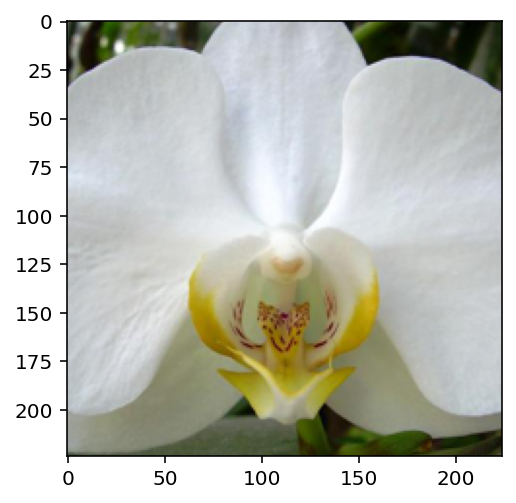

In [13]:
# Output original image
img = random.choice(os.listdir(test_dir +"/7/"))
pil_image = Image.open(test_dir +"/7/" + img)
np_image = process_image(pil_image)
imshow(np_image)

#### **Class Prediction**

##### Once we can get images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. I'll want to calculate the class probabilities then order it to find the $K$ largest values.

To get the top $K$ largest values in a tensor use x.topk(k). This method returns both the highest k probabilities and the indices of those probabilities corresponding to the classes. we need to convert from these indices to the actual class labels using class_to_idx which is added to the model or from an ImageFolder we used to load the data. And invert the dictionary so we can get a mapping from index to class as well.


In [14]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Implement the code to predict the class from an image file
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    pil_image = Image.open(image_path)
    image = process_image(pil_image)

    model.to(device)
    model.eval() # turn off drop out
    
    with torch.no_grad():

        images = torch.from_numpy(np.array([image])).float()
        images = images.to(device) 

        output = model.forward(images)
        ps = torch.exp(output)

        probs, indices = torch.topk(ps, topk)
        probs = [float(prob) for prob in probs[0]]
        invert = {v: k for k, v in image_datasets['train'].class_to_idx.items()}
        classes = [invert[int(index)] for index in indices[0]]
        
    return probs, classes

In [15]:
img = random.choice(os.listdir(test_dir +"/101/"))
image_path = test_dir + "/101/"+ img
prob, classes = predict(image_path, model, topk=5)
print("prob: ", prob)
print("classes: ", classes)
print("category: ",[cat_to_name[x] for x in classes])

prob:  [0.9684303402900696, 0.018289946019649506, 0.003456900827586651, 0.0011507606832310557, 0.0010434677824378014]
classes:  ['101', '51', '43', '53', '86']
category:  ['trumpet creeper', 'petunia', 'sword lily', 'primula', 'tree mallow']


#### **Sanity Checking**

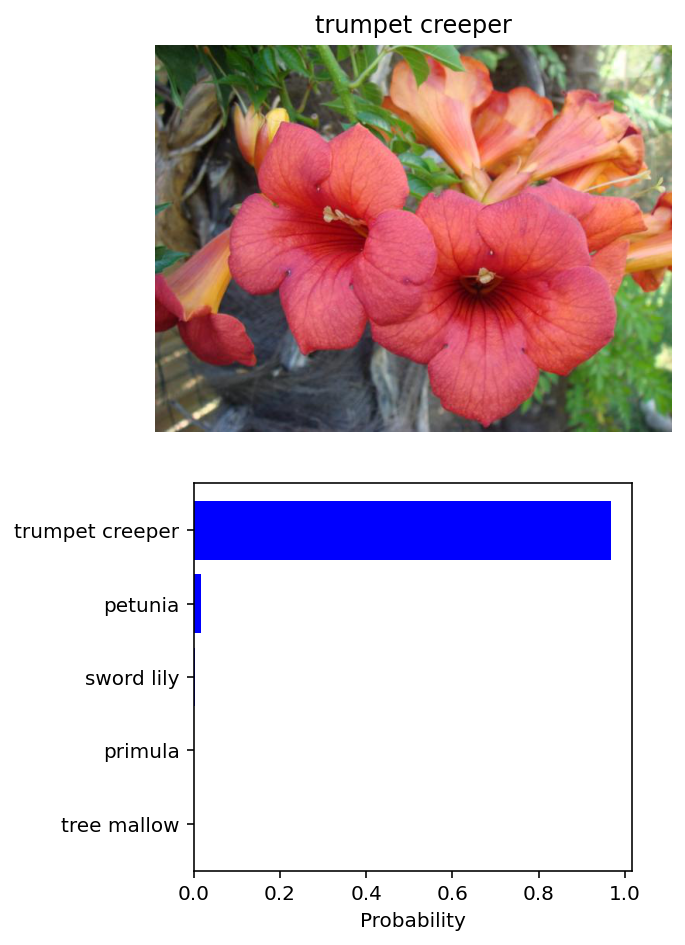

In [16]:
max_index = np.argmax(prob)
max_probability = prob[max_index]
label = classes[max_index]
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((20,10), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((20,10), (10,2), colspan=5, rowspan=9)

image = Image.open(image_path)
ax1.axis('off')
ax1.set_title(cat_to_name[label])
ax1.imshow(image)

labels = []
for cl in classes:
    labels.append(cat_to_name[cl])
    
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, prob, xerr=0, align='center', color='blue')

plt.show()